In [485]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import zscore
from scipy.stats import linregress
from scipy.stats import stats
from pprint import pprint
from datetime import datetime
import os
import gmaps
import seaborn as sns
import re

from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Import API key from a file that is ignored by Git (.gitignore file) so the key isn't exposed to the public
from config import gkey

# Configure gmaps
gmaps.configure(api_key=gkey)

## Store County Health Rankings Excel file results into DataFrame

* Load the excel file imported from https://www.countyhealthrankings.org/app/texas/2019/measure/outcomes/144/description?sort=desc-2

In [2]:
path = "data/2019 County Health Rankings Texas Data - v1_0.xls"

# Get the available sheets in the excel file and put into a list
sheets = pd.ExcelFile(path).sheet_names
print(sheets)

['Introduction', 'Outcomes & Factors Rankings', 'Outcomes & Factors SubRankings', 'Ranked Measure Data', 'Additional Measure Data', 'Ranked Measure Sources & Years', 'Addtl Measure Sources & Years']


## Read in the Ranked Measure Data sheet eliminating columns and extra headers
* Make a list of available columns to decide what we don't want
* Formulate a regex expression to match unwanted columns
* Create a list of only wanted columns to be used for the usecols argument
* Set county to be the index
* Eliminate any row without a county name

In [3]:
# Get the 'Ranked Measure Data' sheet using the sheets list above and rejecting the top header row
rmd = pd.read_excel(path, header=[1], sheet_name=sheets[3])

# View the columns and decide what we don't want
col1 = [col for col in rmd.columns] 
col1.sort()
col1

['# Alcohol-Impaired Driving Deaths',
 '# Associations',
 '# Chlamydia Cases',
 '# Dentists',
 '# Driving Deaths',
 '# Households',
 '# Injury Deaths',
 '# Mental Health Providers',
 '# Primary Care Physicians',
 '# Single-Parent Households',
 '# Some College',
 '# Unemployed',
 '# Uninsured',
 '# Workers who Drive Alone',
 '% Alcohol-Impaired',
 '% Children in Poverty',
 '% Children in Poverty (Black)',
 '% Children in Poverty (Hispanic)',
 '% Children in Poverty (White)',
 '% Drive Alone',
 '% Drive Alone (Black)',
 '% Drive Alone (Hispanic)',
 '% Drive Alone (White)',
 '% Excessive Drinking',
 '% Fair/Poor',
 '% LBW',
 '% LBW (Black)',
 '% LBW (Hispanic)',
 '% LBW (White)',
 '% Long Commute - Drives Alone',
 '% Obese',
 '% Physically Inactive',
 '% Screened',
 '% Screened (Black)',
 '% Screened (Hispanic)',
 '% Screened (White)',
 '% Severe Housing Problems',
 '% Single-Parent Households',
 '% Smokers',
 '% Some College',
 '% Unemployed',
 '% Uninsured',
 '% Vaccinated',
 '% Vaccina

In [4]:
# Create a regular expression to match unwanted columns
regex = '^Z|95|State|Unreliable'

# Use a list comprehension to make a list of columns that don't match the regex (a failed regex match returns 'None')
cols = [col for col in rmd.columns if re.match(regex,col) is None]

# Create a dataframe of the desired columns and set 'County' to the index
rmd_df = pd.read_excel(path, header=[1], sheet_name=sheets[3],usecols=cols)

# Drop any row that has NaN as County value
rmd_df = rmd_df[pd.notnull(rmd_df['County'])]
print(f'shape of rmd_df: {rmd_df.shape}')
rmd_df.head(1)

shape of rmd_df: (254, 87)


,FIPS,County,Years of Potential Life Lost Rate,YPLL Rate (Black),YPLL Rate (Hispanic),YPLL Rate (White),% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,% LBW,...,% Severe Housing Problems,Severe Housing Cost Burden,Overcrowding,Inadequate Facilities,% Drive Alone,% Drive Alone (Black),% Drive Alone (Hispanic),% Drive Alone (White),# Workers who Drive Alone,% Long Commute - Drives Alone
1,48001,Anderson,10272.949118,12962.159784,10880.315229,9971.540573,19.529585,3.92613,3.642847,7.249879,...,15.446669,10.453172,4.30236,1.224978,85.067105,82.663714,81.071311,86.307537,16036,26.8


## Read in the Additional Measure Data sheet eliminating columns and extra headers
* Make a list of available columns to decide what we don't want
* Formulate a regex expression to match unwanted columns
* Create a list of only wanted columns to be used for the usecols argument
* Set county to be the index
* Eliminate any row without a county name

In [5]:
# Get the 'Ranked Measure Data' sheet using the sheets list above and rejecting the top header row
amd = pd.read_excel(path, header=[1], sheet_name=sheets[4])

# View the columns and decide what we don't want
[print(col) for col in amd.columns] 

FIPS
State
County
Life Expectancy
95% CI - Low
95% CI - High
Life Expectancy (Black)
Life Expectancy (Hispanic)
Life Expectancy (White)
# Deaths
Age-Adjusted Mortality
95% CI - Low.1
95% CI - High.1
Age-Adjusted Mortality (Black)
Age-Adjusted Mortality (Hispanic)
Age-Adjusted Mortality (White)
# Deaths.1
Child Mortality Rate
95% CI - Low.2
95% CI - High.2
Child Mortality Rate (Black)
Child Mortality Rate (Hispanic)
Child Mortality Rate (White)
# Deaths.2
Infant Mortality Rate
95% CI - Low.3
95% CI - High.3
Infant Mortality Rate (Black)
Infant Mortality Rate (Hispanic)
Infant Mortality Rate (White)
% Frequent Physical Distress
95% CI - Low.4
95% CI - High.4
% Frequent Mental Distress
95% CI - Low.5
95% CI - High.5
% Diabetic
95% CI - Low.6
95% CI - High.6
# HIV Cases
HIV Prevalence Rate
# Food Insecure
% Food Insecure
# Limited Access
% Limited Access
# Drug Overdose Deaths
Drug Overdose Mortality Rate
# Motor Vehicle Deaths
MV Mortality Rate
95% CI - Low.7
95% CI - High.7
% Insufficien

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
# Create a regular expression to match unwanted columns
regex = '^Z|95|State|Unreliable'

# Use a list comprehension to make a list of columns that don't match the regex (a failed regex match returns 'None')
cols = [col for col in amd.columns if re.match(regex,col) is None]

# Create a dataframe of the desired columns and set 'County' to the index
amd_df = pd.read_excel(path, header=[1], sheet_name=sheets[4],usecols=cols)

# Drop any row that has Nan as County value
amd_df = amd_df[pd.notnull(amd_df['County'])]
print(f'shape of rmd_df: {amd_df.shape}')
amd_df.head(1)

shape of rmd_df: (254, 76)


,FIPS,County,Life Expectancy,Life Expectancy (Black),Life Expectancy (Hispanic),Life Expectancy (White),# Deaths,Age-Adjusted Mortality,Age-Adjusted Mortality (Black),Age-Adjusted Mortality (Hispanic),...,% Native Hawaiian/Other Pacific Islander,# Hispanic,% Hispanic,# Non-Hispanic White,% Non-Hispanic White,# Not Proficient in English,% Not Proficient in English,% Female,# Rural,% Rural
1,48001,Anderson,73.773772,70.933226,82.901506,74.097055,1075.0,544.0,721.905041,597.224357,...,0.143745,10287,17.815763,34140,59.126098,1488,2.715874,39.06756,39204,67.063533


In [7]:
# Merge the rmd and amd dataframes using inner join on County column (index)
merged_df = pd.merge(rmd_df,amd_df, how='inner', on='County')
print(f'shape of merged_df: {merged_df.shape}')
#merged_df.head(1)

shape of merged_df: (254, 162)


In [8]:
# View the columns that end in '_x' or '_y'
regex2 = '.*_x$|.*_y$'
[print(col) for col in merged_df.columns if re.match(regex2,col) is not None]

FIPS_x
# Uninsured_x
% Uninsured_x
Population_x
FIPS_y
# Uninsured_y
% Uninsured_y
Population_y


[None, None, None, None, None, None, None, None]

In [9]:
# Drop the duplicate _y columns
regex3 = '.*_y$'
merged_df.drop([col for col in merged_df.columns if re.match(regex3,col) is not None],axis=1, inplace=True)
print(merged_df.shape)

(254, 158)


In [10]:
# Rename the columns to eliminate the '_x' leftover from the join
merged_df.rename(columns = {'FIPS_x':'FIPS',\
                                        '# Uninsured_x':'# Uninsured',\
                                        '% Uninsured_x':'% Uninsured',\
                                        'Population_x':'Population'},\
                                         inplace=True)
#merged_df.columns
# View the columns that end in '_x' or '_y'
regex2 = '.*_x$|.*_y$'
[print(col) for col in merged_df.columns if re.match(regex2,col) is not None] 

[]

## Store NCHS Urban Rural Classification System Excel file results into DataFrame

* Load the excel file imported from https://www.cdc.gov/nchs/data_access/urban_rural.htm#Data_Files_and_Documentation
* No description or label was given in the 'NCHS URCS' - only numbers 1-6. Reading the file documentation gave this information, so an excel sheet was created and a VLOOKUP mapped the names and descriptions to the classification numbers. The result excel file will be imported and joined to the merged_df

In [11]:
path2 = 'data/NCHS Urban Rural Classification System.xlsx'

# Get the available sheets in the excel file and put into a list
sheets2 = pd.ExcelFile(path2).sheet_names
print(sheets2)

['URCS', 'Legend']


In [12]:
# Get the 'URCS' sheet using the sheets list above and rejecting the top header row
cs = pd.read_excel(path2)
cs.columns
cs.head(1)


,FIPS code,State Abr.,County name,CBSA title,CBSA 2012 pop,County 2012 pop,2013 code,2006 code,1990-based code,URCS,URCS Name,URCS description
0,1073,AL,Jefferson County,"Birmingham-Hoover, AL",1136650,660009,1,1,3,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m..."


In [13]:
# Get the 'URCS' sheet using the columns list above
urcs = pd.read_excel(path2,usecols=['FIPS code','URCS','URCS Name','URCS description'],index_col=0)
print(f'shape of urcs: {urcs.shape}')


shape of urcs: (3149, 3)


In [14]:
# Drop any row that has Nan as an index value
urcs = urcs.loc[urcs.index.dropna()]
print(f'shape of urcs: {urcs.shape}')

shape of urcs: (3149, 3)


In [15]:
# Check that all FIPS in the merged_df are in the urcs.index (urcs index has ALL counties in USA not just Texas)
print(f"merged_df FIPS:{[mips for mips in merged_df['FIPS'] if mips not in urcs.index]} not found in urcs.index")
#print(f'urcs county:{[county for county in urcs.index if county not in merged_df["FIPS"]]} not found in merged_df.index')

merged_df FIPS:[] not found in urcs.index


In [16]:
# Rename the index 'FIPS code' to FIPS
urcs.rename_axis('FIPS', axis=0, inplace=True)
urcs.head()

,URCS,URCS Name,URCS description
FIPS,,,
1073,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m..."
4013,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m..."
6001,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m..."
6037,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m..."
6059,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m..."


# Merge the NCHS URCS data with the merged_df

In [163]:
all_df = pd.merge(urcs,merged_df, how='inner', on='FIPS')
#print(all_df.shape)
all_df.head(1)

,FIPS,URCS,URCS Name,URCS description,County,Years of Potential Life Lost Rate,YPLL Rate (Black),YPLL Rate (Hispanic),YPLL Rate (White),% Fair/Poor,...,% Native Hawaiian/Other Pacific Islander,# Hispanic,% Hispanic,# Non-Hispanic White,% Non-Hispanic White,# Not Proficient in English,% Not Proficient in English,% Female,# Rural,% Rural
0,48029,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m...",Bexar,6930.930981,9500.237875,6729.699925,6981.54228,23.789874,...,0.221691,1181315,60.314933,543068,27.727668,104033,5.926969,50.634542,77835,4.539085


In [162]:
multi_df = all_df.set_index(['URCS','URCS Name','County'])
multi_df = multi_df.sort_index()

print(multi_df.shape)
multi_df.head(50)

(254, 158)


FIPS  \
URCS  URCS Name    County               
Rural Micropolitan Anderson     48001   
                   Andrews      48003   
                   Angelina     48005   
                   Bee          48025   
                   Brown        48049   
                   Calhoun      48057   
                   Cherokee     48073   
                   Cooke        48097   
                   Dawson       48115   
                   Deaf Smith   48117   
                   Erath        48143   
                   Gillespie    48171   
                   Glasscock    48173   
                   Gray         48179   
                   Hale         48189   
                   Harrison     48203   
                   Henderson    48213   
                   Hockley      48219   
                   Hopkins      48223   
                   Howard       48227   
                   Hutchinson   48233   
                   Jim Wells    48249   
                   Kenedy       48261   
                   Kerr         48265   
                   Kleberg      48273   
                   Lamar        48277   
                   Matagorda    48321   
                   Maverick     48323   
                   Moore        48341   
                   Nacogdoches  48347   
                   Navarro      48349   
                   Nolan        48353   
                   Palo Pinto   48363   
                   Reeves       48389   
                   Scurry       48415   
                   Starr        48427   
                   Titus        48449   
                   Trinity      48455   
                   Uvalde       48463   
                   Val Verde    48465   
                   Walker       48471   
                   Washington   48477   
                   Wharton      48481   
                   Wilbarger    48487   
                   Willacy      48489   
                   Zapata       48505   
      Noncore      Bailey       48017   
                   Baylor       48023   
                   Blanco       48031   
                   Borden       48033   

                                                                 URCS description  \
URCS  URCS Name    County                                                           
Rural Micropolitan Anderson            Counties in micropolitan statistical areas   
                   Andrews             Counties in micropolitan statistical areas   
                   Angelina            Counties in micropolitan statistical areas   
                   Bee                 Counties in micropolitan statistical areas   
                   Brown               Counties in micropolitan statistical areas   
                   Calhoun             Counties in micropolitan statistical areas   
                   Cherokee            Counties in micropolitan statistical areas   
                   Cooke               Counties in micropolitan statistical areas   
                   Dawson              Counties in micropolitan statistical areas   
                   Deaf Smith          Counties in micropolitan statistical areas   
                   Erath               Counties in micropolitan statistical areas   
                   Gillespie           Counties in micropolitan statistical areas   
                   Glasscock           Counties in micropolitan statistical areas   
                   Gray                Counties in micropolitan statistical areas   
                   Hale                Counties in micropolitan statistical areas   
                   Harrison            Counties in micropolitan statistical areas   
                   Henderson           Counties in micropolitan statistical areas   
                   Hockley             Counties in micropolitan statistical areas   
                   Hopkins             Counties in micropolitan statistical areas   
                   Howard              Counties in micropolitan statistical areas   
                   Hutchinson 

In [849]:
rural_df = multi_df.loc['Rural']
print(rural_df.shape)

(172, 158)


In [850]:
urban_df = multi_df.loc['Urban']
print(urban_df.shape)

(82, 158)


## Function to easily do a panel of scatterplots easily

In [340]:
def makePanelScatterplot(data_df, x_data,y_data,color_col,split_col):
    x_label = x_data
    y_label = y_data
    ylim_min = data_df[y_data].min()*1.05
    ylim_max = data_df[y_data].max()*1.05
    xlim_min = data_df[x_data].min()*1.05
    xlim_max = data_df[x_data].max()*1.05

    g = sns.lmplot(x=x_data, y=y_data, data=data_df,\
           hue=color_col, col=split_col,col_wrap=3)

        
    g = (g.set_axis_labels(x_label, y_label)
          .set(ylim=(ylim_min, ylim_max),xlim=(xlim_min, xlim_max))
          .fig.subplots_adjust(wspace=.02))

## Function to call OLS Regression Statsmodel from 2 columns of dataframe

In [446]:
def olsRegressionAnalysis (df,df_name,dep_col,ind_col):
    stat_dep_col = dep_col.replace(' ','_').replace('-','_').replace('(','_').replace(')','')
    stat_ind_col = ind_col.replace(' ','_').replace('-','_').replace('(','_').replace(')','')
    stat_col_list = [stat_dep_col,stat_ind_col]
    #print(f'stat_dep_col: {stat_dep_col}, stat_ind_col: {stat_ind_col}')
    col_list = [dep_col,ind_col]

    col_dict = {col_list[i]: stat_col_list[i] for i in range(len(col_list))} 
    #print(col_dict)
    stat_df = df[col_list].dropna()
    stat_df.rename(columns=col_dict,inplace=True)
    print(f'\u001b[34m{dep_col}\u001b[0m fitted against \u001b[34m{ind_col}\u001b[0m using \x1b[31m{df_name}\x1b[0m dataframe:\n')
    print(f'We have {stat_df.shape[0]} rows left after dropping Null values\n')
    model_string = stat_dep_col + " ~ " + stat_ind_col
    all_model = ols(model_string, data=stat_df).fit()
    print(all_model.summary())

## Spot check for outliers for our dependent variable 'Age-Adjusted Mortality' (AAMR)

[Text(0, 0, 'Urban'), Text(0, 0, 'Rural')]

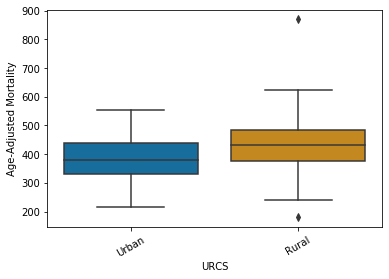

In [938]:
# Run a boxplot of the Urban vs.Rural AAMR
g = sns.boxplot(y='Age-Adjusted Mortality', x='URCS', 
                 data=all_df, 
                 palette="colorblind")
g.set_xticklabels(g.get_xticklabels(), rotation=30)

[Text(0, 0, 'Large central metro'),
 Text(0, 0, 'Large fringe metro'),
 Text(0, 0, 'Medium metro'),
 Text(0, 0, 'Small metro'),
 Text(0, 0, 'Micropolitan'),
 Text(0, 0, 'Noncore')]

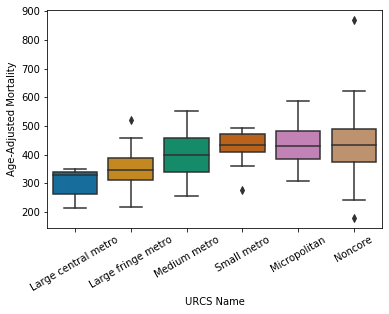

In [940]:
g = sns.boxplot(y='Age-Adjusted Mortality', x='URCS Name', 
                 data=all_df, 
                 palette="colorblind")
g.set_xticklabels(g.get_xticklabels(), rotation=30)

## Clean each column of the dataframe for outliers in each column

For each URCS Name we will make a dataframe and then act on each column to substitute a NaN value for the outlier.
The cutoff for outliers will be set to a zscore of greater than 2 (So we keep the actual value where zscore < 2 in our mask)

In [941]:
# First cut the urban_df for the URCS Name value (shown in the box plot above)
lcm_df = urban_df.loc['Large central metro']
# Drop the non-numeric columns (they will throw an error if we try to calculate a zscore)
lcm_df = lcm_df.drop(["URCS description","PCP Ratio","Dentist Ratio",\
               "MHP Ratio","Presence of violation","Other PCP Ratio"], axis=1)
# Fill the NaN values with zeros - otherwise the zscore mask will replace all values in the column with NaN
lcm_df = lcm_df.fillna(0)
# Apply a condition to every column to replace any value with a zscore < 2 with NaN
lcm_df = lcm_df.where(lcm_df.apply(zscore).lt(2))
# Transform all the zero values back to NaN
lcm_df.replace(0, np.nan, inplace=True)
# Reset the Index to put the indexes back into columns 
lcm_df.reset_index(inplace=True)  

In [942]:
# Repeat procedure for each value of the URCS Name value - see above cell comments for logic
lfm_df = urban_df.loc['Large fringe metro']
lfm_df = lfm_df.drop(["URCS description","PCP Ratio","Dentist Ratio",\
               "MHP Ratio","Presence of violation","Other PCP Ratio"], axis=1)
lfm_df = lfm_df.fillna(0)
lfm_df = lfm_df.where(lfm_df.apply(zscore).lt(2))
lfm_df.replace(0, np.nan, inplace=True)
lfm_df.reset_index(inplace=True) 

In [943]:
# Repeat procedure for each value of the URCS Name value - see above cell comments for logic
mm_df = urban_df.loc['Medium metro']
mm_df = mm_df.drop(["URCS description","PCP Ratio","Dentist Ratio",\
               "MHP Ratio","Presence of violation","Other PCP Ratio"], axis=1)
mm_df = mm_df.fillna(0)
mm_df = mm_df.where(mm_df.apply(zscore).lt(2))
mm_df.replace(0, np.nan, inplace=True)
mm_df.reset_index(inplace=True) 

In [944]:
# Repeat procedure for each value of the URCS Name value - see above cell comments for logic
sm_df = urban_df.loc['Small metro']
#sm_df['Age-Adjusted Mortality']
sm_df = sm_df.drop(["URCS description","PCP Ratio","Dentist Ratio",\
               "MHP Ratio","Presence of violation","Other PCP Ratio"], axis=1)
sm_df =sm_df.fillna(0)
sm_df = sm_df.where(sm_df.apply(zscore).lt(2))
sm_df[sm_df['Age-Adjusted Mortality'] < 300] = np.nan
sm_df.replace(0, np.nan, inplace=True)
sm_df.reset_index(inplace=True) 
#sm_df['Age-Adjusted Mortality']

In [946]:
# Repeat procedure for each value of the URCS Name value - see above cell comments for logic
mp_df = rural_df.loc['Micropolitan']
mp_df = mp_df.drop(["URCS description","PCP Ratio","Dentist Ratio",\
               "MHP Ratio","Presence of violation","Other PCP Ratio"], axis=1)
mp_df = mp_df.fillna(0.000001)
mp_df = mp_df.where(mp_df.apply(zscore).lt(2))
#mp_df = mp_df.where(mp_df.apply(zscore).gt(2))
mp_df.replace(0.000001, np.nan, inplace=True)
mp_df.reset_index(inplace=True)

In [947]:
# Repeat procedure for each value of the URCS Name value - see above cell comments for logic
nc_df = rural_df.loc['Noncore']
nc_df = nc_df.drop(["URCS description","PCP Ratio","Dentist Ratio",\
               "MHP Ratio","Presence of violation","Other PCP Ratio"], axis=1)
nc_df = nc_df.fillna(0)
nc_df = nc_df.where(nc_df.apply(zscore).abs().lt(2))
nc_df[nc_df['Age-Adjusted Mortality'] < 200] = np.nan
nc_df.replace(0, np.nan, inplace=True)
nc_df.reset_index(inplace=True) 
#nc_df['Age-Adjusted Mortality']

In [948]:
# Concatonate all the partial dataframes that have removed outliers relative to their URCS Name classification
clean_df = pd.concat([lcm_df, lfm_df, mm_df, sm_df, mp_df, nc_df])

In [949]:
# Merge the clean dataframe back with the urcs dataframe to add back the URCS columns
all_clean_df = pd.merge(urcs,clean_df, how='inner', on='FIPS')
print(all_clean_df.shape)

(251, 156)


In [950]:
# Set index to a multiindex again using 3 columns
multi_clean_df = all_clean_df.set_index(['URCS','URCS Name','County'])
multi_clean_df = multi_clean_df.sort_index()
print(multi_clean_df.shape)

(251, 153)


## Regenerate clean urban_df and rural_df from multi_clean_df

In [955]:
rural_clean_df = multi_clean_df.loc['Rural']
print(rural_df.shape)

(172, 158)


In [956]:
urban_clean_df = multi_clean_df.loc['Urban']
print(urban_df.shape)

(82, 158)


In [988]:
lcm_clean_df = urban_clean_df.loc['Large central metro']
lfm_clean_df = urban_clean_df.loc['Large fringe metro']
mm_clean_df = urban_clean_df.loc['Medium metro']
sm_clean_df = urban_clean_df.loc['Small metro']
mp_clean_df = rural_clean_df.loc['Micropolitan']
nc_clean_df = rural_clean_df.loc['Noncore']

## Rerun Box plot to verify no outliers for our dependent variable 'Age-Adjusted Mortality'

[Text(0, 0, 'Urban'), Text(0, 0, 'Rural')]

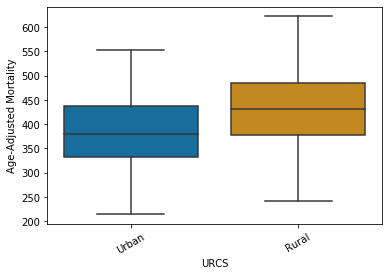

In [957]:
g = sns.boxplot(y='Age-Adjusted Mortality', x='URCS', 
                 data=all_clean_df, 
                 palette="colorblind")
g.set_xticklabels(g.get_xticklabels(), rotation=30)

# Is there a significant difference between Urban and Rural populations?


In [958]:
# Create a series of just the Urban,AAMR data and also Rural,AAMR
urban_aamr = multi_clean_df.loc['Urban','Age-Adjusted Mortality'].dropna()
rural_aamr = multi_clean_df.loc['Rural','Age-Adjusted Mortality'].dropna()

# Run a t-test between the urban and rural Age-Adjusted Mortality
stats.ttest_ind(urban_aamr, rural_aamr, equal_var=False)

Ttest_indResult(statistic=-4.731900084902864, pvalue=5.013491835981784e-06)

#### The pvalue is much greater than 0.05 so there is no statistically significant difference between Urban and Rural populations with respect to measuring AAMR

So the question is: If we segment our Urban and Rural populations using the URCS Classification scheme will we see a difference among the subpopulations of Urban and Rural?

[Text(0, 0, 'Large central metro'),
 Text(0, 0, 'Large fringe metro'),
 Text(0, 0, 'Medium metro'),
 Text(0, 0, 'Small metro'),
 Text(0, 0, 'Micropolitan'),
 Text(0, 0, 'Noncore')]

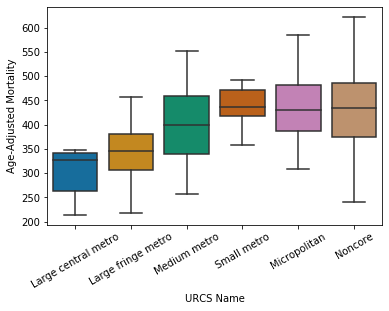

In [959]:
g = sns.boxplot(y='Age-Adjusted Mortality', x='URCS Name', 
                 data=all_clean_df, 
                 palette="colorblind")
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [967]:
# Create a series of just the Urban,AAMR data and also Rural,AAMR for each group
lcm_aamr = urban_clean_df.loc['Large central metro','Age-Adjusted Mortality'].dropna()
lfm_aamr = urban_clean_df.loc['Large fringe metro','Age-Adjusted Mortality'].dropna()
mm_aamr = urban_clean_df.loc['Medium metro','Age-Adjusted Mortality'].dropna()
sm_aamr = urban_clean_df.loc['Small metro','Age-Adjusted Mortality'].dropna()
mp_aamr = rural_clean_df.loc['Micropolitan','Age-Adjusted Mortality'].dropna()
nc_aamr = rural_clean_df.loc['Noncore','Age-Adjusted Mortality'].dropna()

## Test 'Large central metro' (lcm) area against both 'Micropolitan' (mp) and 'Noncore' (nc) rural areas using a t-test

In [966]:
# Run a t-test between the urban lcm and rural mp for Age-Adjusted Mortality
stats.ttest_ind(lcm_aamr, mp_aamr, equal_var=False)

Ttest_indResult(statistic=-5.17916727114997, pvalue=0.0013662029029729151)

In [965]:
# Run a t-test between the urban lcm and rural nc for Age-Adjusted Mortality
stats.ttest_ind(lcm_aamr, nc_aamr, equal_var=False)

Ttest_indResult(statistic=-5.360783209206877, pvalue=0.0015806648534332046)

### The lcm urban area has a significantly better health outcome against both rural areas mp and nc
The pvalues of 0.0014 and 0.0016 show a statistically significant better outcome for lcm vs. both mp and nc 

## Test 'Large central metro' (lcm) area against remaining 'Large fringe metro' (lfm), 'Medium metro' (mm) and 'Small metro' (sm) urban areas using a t-test

In [970]:
# Run a t-test between the urban lcm and urban lfm for Age-Adjusted Mortality
stats.ttest_ind(lcm_aamr, lfm_aamr, equal_var=False)

Ttest_indResult(statistic=-1.3423352117863, pvalue=0.21749505027772037)

In [971]:
# Run a t-test between the urban lcm and urban mm for Age-Adjusted Mortality
stats.ttest_ind(lcm_aamr, mm_aamr, equal_var=False)

Ttest_indResult(statistic=-3.6000176726999022, pvalue=0.004034765207805986)

In [972]:
# Run a t-test between the urban lcm and urban sm for Age-Adjusted Mortality
stats.ttest_ind(lcm_aamr, sm_aamr, equal_var=False)

Ttest_indResult(statistic=-5.418686036720096, pvalue=0.0012260087702403997)

### The lcm urban area has a significantly better health outcome against both urban areas mm and sm but not against lfm
The pvalues of 0.0040 and 0.0012 show a statistically significant better outcome for lcm vs. both mm and sm but
the pvalue of 0.2175 does not show a statistically significant difference in health outcome as measured by AAMR

## Test 'Large fringe metro' (lfm) area against both 'Micropolitan' (mp) and 'Noncore' (nc) rural areas using a t-test

In [968]:
# Run a t-test between the urban lfm and rural mp for Age-Adjusted Mortality
stats.ttest_ind(lfm_aamr, mp_aamr, equal_var=False)

Ttest_indResult(statistic=-6.299666267651455, pvalue=4.025405061713767e-08)

In [969]:
# Run a t-test between the urban lfm and rural nc for Age-Adjusted Mortality
stats.ttest_ind(lfm_aamr, nc_aamr, equal_var=False)

Ttest_indResult(statistic=-6.884982635586501, pvalue=6.538130703639622e-09)

### The lfm urban area is NOT significantly better health outcome against both rural areas mp and nc
The pvalues of 4.025 and 6.538 do not show a statistically significant better outcome for lcm vs. both mp and nc

# What factors correlate with AAMR?

We will run a Pearson's correlation matrix to examine each factor against every other factor

In [22]:
corr1 = multi_df.corr()

In [23]:
corr1.to_csv('Corr1.csv')

In [24]:
multi_df.to_csv('multi_df.csv')

In [25]:
corr1_spear = multi_df.corr(method='spearman')

In [26]:
corr1_spear.to_csv('Corr1_spear.csv')

## Age adjusted Mortality (Deaths/100k) vs. Household Income for Everyone

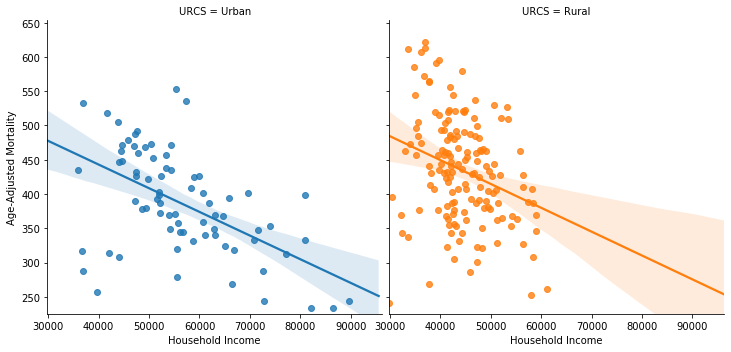

In [922]:
makePanelScatterplot(all_clean_df,"Household Income","Age-Adjusted Mortality","URCS","URCS")

## Statistically Examine the Urban AAMR vs.Household Income (HI)

 First run a regression analysis using the ols and statsmodel packages
 We are interested in the R-squared value F-statistic and the pvalue (P>|t|) for the t-test of the independent variable against the dependent variable ( pvalue < 0.05 is good )

In [923]:
olsRegressionAnalysis(urban_clean_df,"urban_clean_df","Age-Adjusted Mortality","Household Income")

Age-Adjusted Mortality fitted against Household Income using urban_clean_df dataframe:

We have 76 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.305
Method:                     Least Squares   F-statistic:                     33.92
Date:                    Fri, 31 Jan 2020   Prob (F-statistic):           1.39e-07
Time:                            13:59:31   Log-Likelihood:                -423.90
No. Observations:                      76   AIC:                             851.8
Df Residuals:                          74   BIC:                             856.5
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    st

### The R-squared value for Urban AAMR vs. HI is 0.314 which shows an ok linear regression relationship
The pvalue for the t-test of Household Income vs. AAMR shows that we can reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables

In [982]:
olsRegressionAnalysis(rural_clean_df,"rural_clean_df","Age-Adjusted Mortality","Household Income")

Age-Adjusted Mortality fitted against Household Income using rural_clean_df dataframe:

We have 156 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.088
Model:                                OLS   Adj. R-squared:                  0.082
Method:                     Least Squares   F-statistic:                     14.86
Date:                    Fri, 31 Jan 2020   Prob (F-statistic):           0.000170
Time:                            15:35:49   Log-Likelihood:                -894.06
No. Observations:                     156   AIC:                             1792.
Df Residuals:                         154   BIC:                             1798.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    s

### The R-Squared value for Rural  AAMR vs. HI is 0.088 which shows relatively no relationship 
The pvalue for the t-test of Household Income vs. AAMR shows that we can reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables ablbeit a very weak one based on the R-Squared value

## What if we examine this relationship segmented by the URCS?

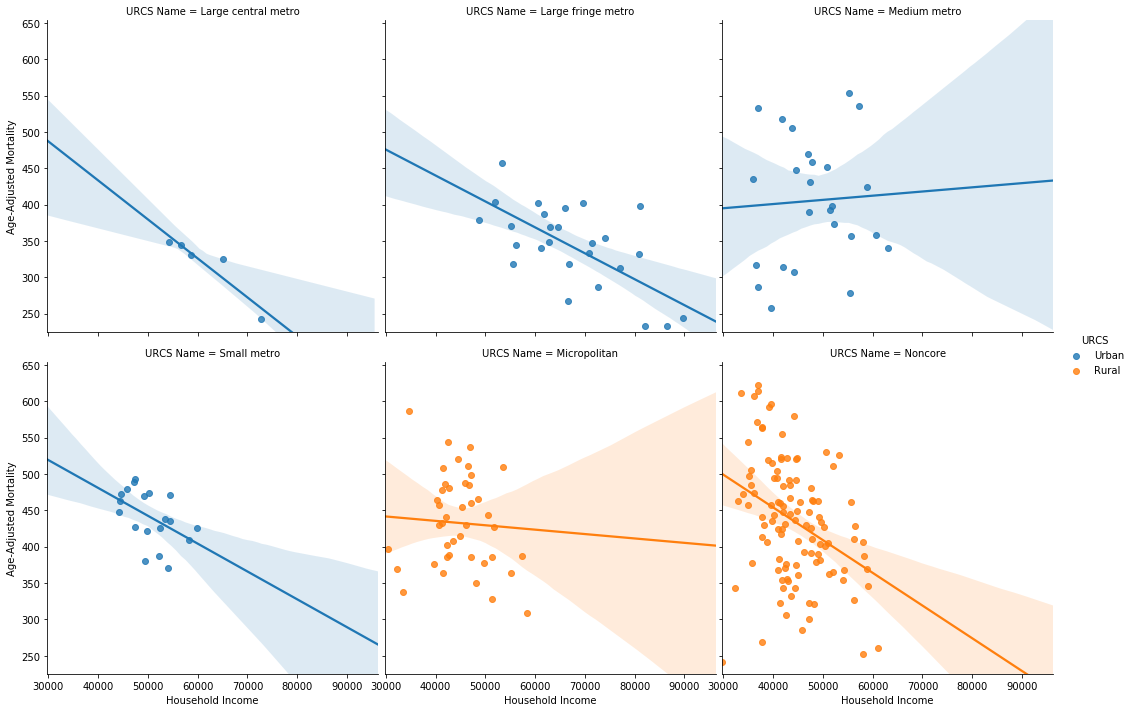

In [983]:
makePanelScatterplot(all_clean_df,"Household Income","Age-Adjusted Mortality","URCS","URCS Name")

Most of these are obviously NOT correlated linearly upon visual inspection - so we will only test two

## Statistically Examine the Urban Large central metro & Large fringe metro AAMR vs.Household Income (HI)

 First run a regression analysis using the ols and statsmodel packages
 We are interested in the R-squared value F-statistic and the pvalue (P>|t|) for the t-test of the independent variable against the dependent variable ( pvalue < 0.05 is good )

In [993]:
olsRegressionAnalysis(lcm_clean_df,"lcm_clean_df","Age-Adjusted Mortality","Household Income")

Age-Adjusted Mortality fitted against Household Income using lcm_clean_df dataframe:

We have 5 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.872
Model:                                OLS   Adj. R-squared:                  0.829
Method:                     Least Squares   F-statistic:                     20.43
Date:                    Fri, 31 Jan 2020   Prob (F-statistic):             0.0202
Time:                            15:54:32   Log-Likelihood:                -20.209
No. Observations:                       5   AIC:                             44.42
Df Residuals:                           3   BIC:                             43.64
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    std e

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


### The R-squared value for Urban Large central metro AAMR vs. HI is 0.872 which shows an great linear regression relationship - however the small sample size of n = 5 renders this result dubious
The pvalue for the t-test of Household Income vs. AAMR of 0.02 shows that we can reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables

In [994]:
olsRegressionAnalysis(lfm_clean_df,"lfm_clean_df","Age-Adjusted Mortality","Household Income")

Age-Adjusted Mortality fitted against Household Income using lfm_clean_df dataframe:

We have 27 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.478
Model:                                OLS   Adj. R-squared:                  0.457
Method:                     Least Squares   F-statistic:                     22.89
Date:                    Fri, 31 Jan 2020   Prob (F-statistic):           6.52e-05
Time:                            15:56:44   Log-Likelihood:                -139.83
No. Observations:                      27   AIC:                             283.7
Df Residuals:                          25   BIC:                             286.2
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    std 

### The R-squared value for Urban Large fringe metro AAMR vs. HI is 0.478 which shows an good linear regression relationship
The pvalue for the t-test of Household Income vs. AAMR of 0.00 shows that we can reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables

# Age adjusted Mortality (Deaths/100k) for Blacks

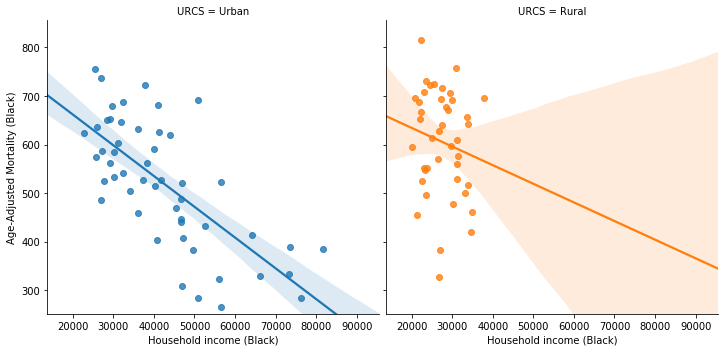

In [1000]:
makePanelScatterplot(all_clean_df,"Household income (Black)","Age-Adjusted Mortality (Black)","URCS","URCS")

## Statistically Examine the Urban AAMR vs.Household Income (HI) for Blacks

 First run a regression analysis using the ols and statsmodel packages
 We are interested in the R-squared value F-statistic and the pvalue (P>|t|) for the t-test of the independent variable against the dependent variable ( pvalue < 0.05 is good )

In [1006]:
olsRegressionAnalysis(urban_clean_df,"urban_clean_df","Age-Adjusted Mortality","Household income (Black)")

Age-Adjusted Mortality fitted against Household income (Black) using urban_clean_df dataframe:

We have 63 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.532
Model:                                OLS   Adj. R-squared:                  0.524
Method:                     Least Squares   F-statistic:                     69.25
Date:                    Fri, 31 Jan 2020   Prob (F-statistic):           1.23e-11
Time:                            16:08:44   Log-Likelihood:                -340.35
No. Observations:                      63   AIC:                             684.7
Df Residuals:                          61   BIC:                             689.0
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                         

### The R-squared value for Urban AAMR vs. HI is 0.314 which shows an ok linear regression relationship
The pvalue for the t-test of Household Income vs. AAMR shows that we can reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables

In [1007]:
olsRegressionAnalysis(rural_clean_df,"rural_clean_df","Age-Adjusted Mortality","Household income (Black)")

Age-Adjusted Mortality fitted against Household income (Black) using rural_clean_df dataframe:

We have 84 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.089
Model:                                OLS   Adj. R-squared:                  0.077
Method:                     Least Squares   F-statistic:                     7.963
Date:                    Fri, 31 Jan 2020   Prob (F-statistic):            0.00599
Time:                            16:09:03   Log-Likelihood:                -470.11
No. Observations:                      84   AIC:                             944.2
Df Residuals:                          82   BIC:                             949.1
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                         

### The R-Squared value for Rural  AAMR vs. HI is 0.088 which shows relatively no relationship 
The pvalue for the t-test of Household Income vs. AAMR shows that we can reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables ablbeit a very weak one based on the R-Squared value

## What if we examine this relationship segmented by the URCS?

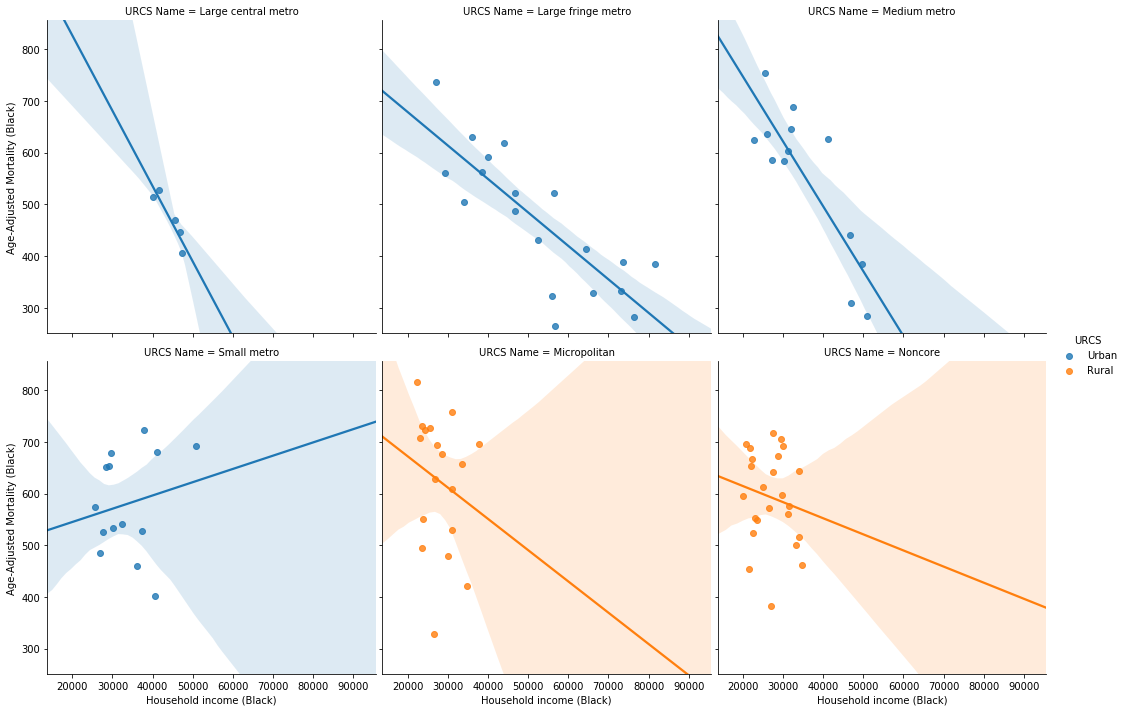

In [1008]:
makePanelScatterplot(all_clean_df,"Household income (Black)","Age-Adjusted Mortality (Black)","URCS","URCS Name")

# Age adjusted Mortality (Deaths/100k) for Whites

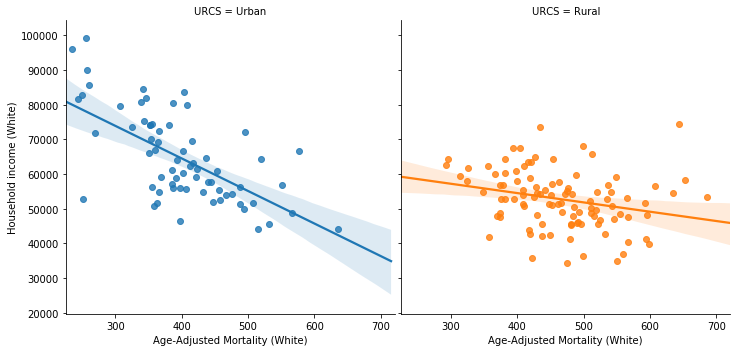

In [846]:
makePanelScatterplot(all_clean_df,"Age-Adjusted Mortality (White)","Household income (White)","URCS","URCS")

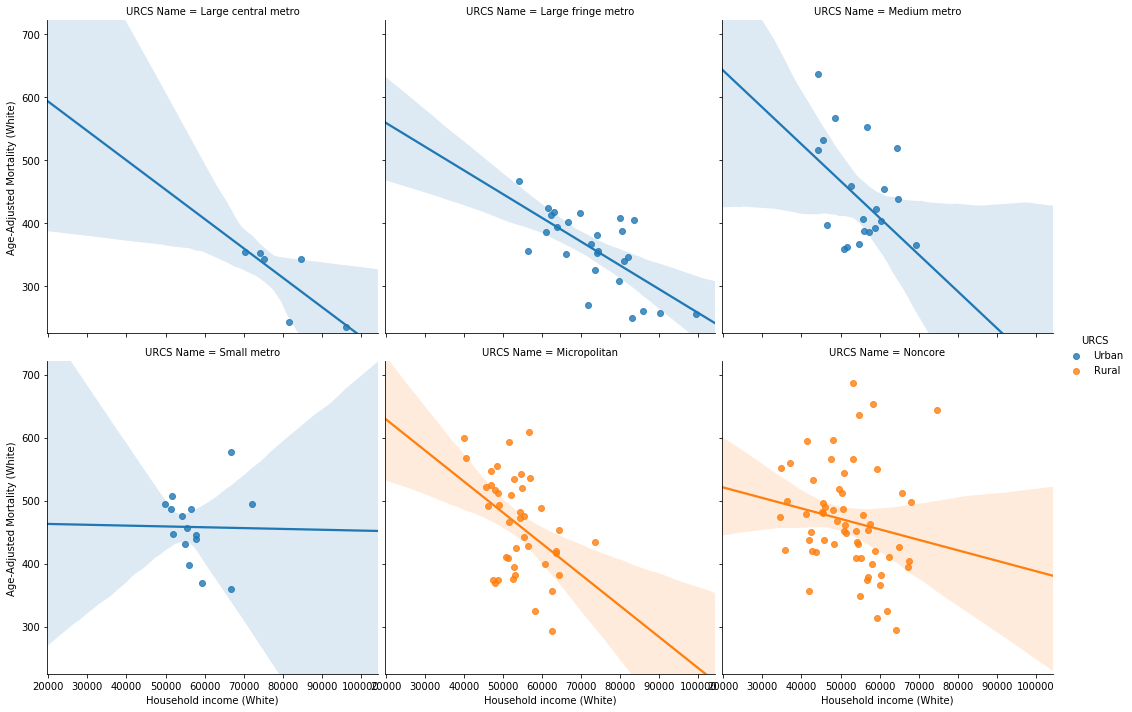

In [1009]:
makePanelScatterplot(all_clean_df,"Household income (White)","Age-Adjusted Mortality (White)","URCS","URCS Name")

# Age adjusted Mortality (Deaths/100k) for Hispanics

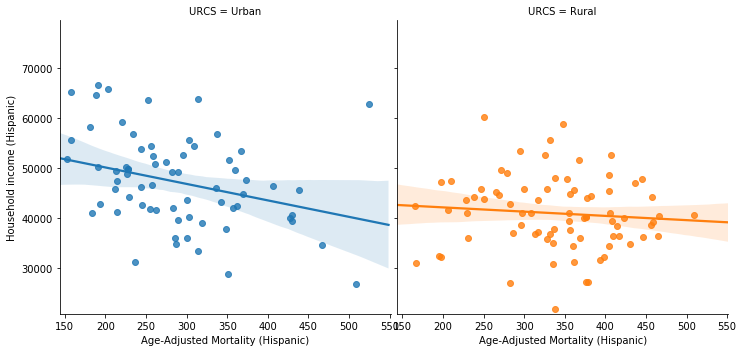

In [1011]:
makePanelScatterplot(all_clean_df,"Age-Adjusted Mortality (Hispanic)","Household income (Hispanic)","URCS","URCS")

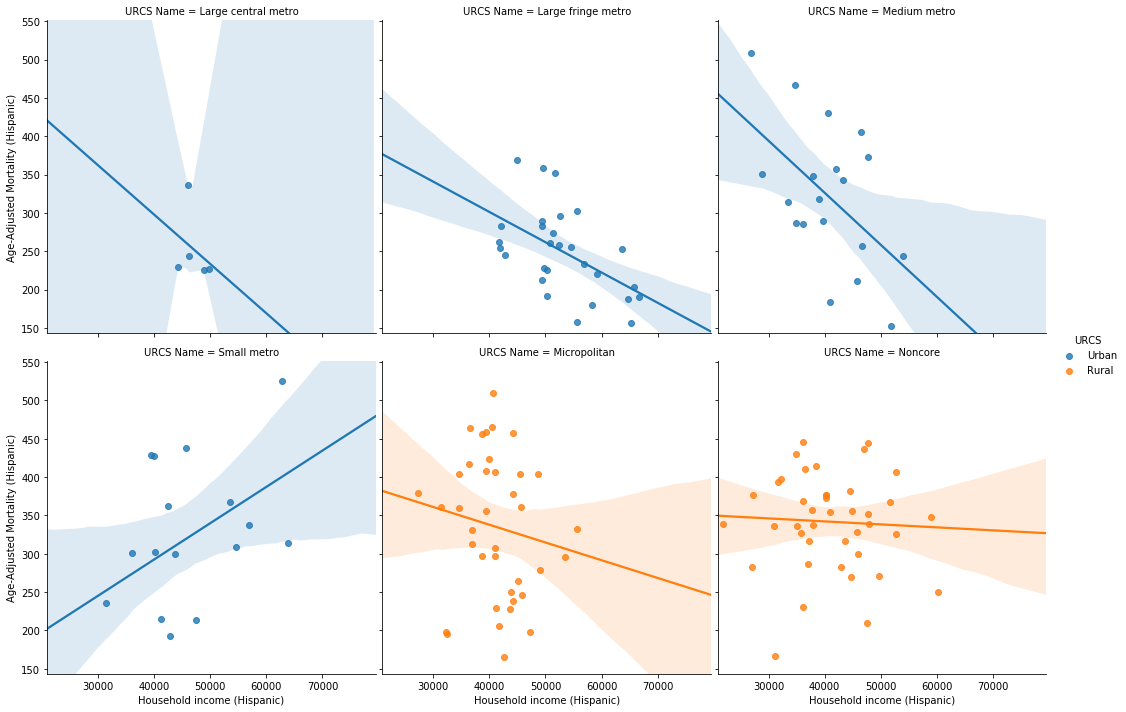

In [1010]:
makePanelScatterplot(all_clean_df,"Household income (Hispanic)","Age-Adjusted Mortality (Hispanic)","URCS","URCS Name")

In [1017]:
# View the columns that contain 'Black'
regex4 = '.*Black.*'
cols_black = [col for col in multi_clean_df.columns if re.match(regex4,col) is not None] 
cols_black

['YPLL Rate (Black)',
 '% LBW (Black)',
 'Teen Birth Rate (Black)',
 'Preventable Hosp. Rate (Black)',
 '% Screened (Black)',
 '% Vaccinated (Black)',
 '% Children in Poverty (Black)',
 '% Drive Alone (Black)',
 'Life Expectancy (Black)',
 'Age-Adjusted Mortality (Black)',
 'Child Mortality Rate (Black)',
 'Infant Mortality Rate (Black)',
 'Household income (Black)']

In [1012]:
#all_df.columns.values

In [120]:
indexes = [0,8,10,11]
for index in sorted(indexes, reverse=True):
    del cols_black[index]
cols_black

['% LBW (Black)',
 'Teen Birth Rate (Black)',
 'Preventable Hosp. Rate (Black)',
 '% Screened (Black)',
 '% Vaccinated (Black)',
 '% Children in Poverty (Black)',
 '% Drive Alone (Black)',
 'Age-Adjusted Mortality (Black)',
 'Household income (Black)']

In [1018]:
black_df = multi_clean_df[cols_black]
black_df.columns

Index(['YPLL Rate (Black)', '% LBW (Black)', 'Teen Birth Rate (Black)',
       'Preventable Hosp. Rate (Black)', '% Screened (Black)',
       '% Vaccinated (Black)', '% Children in Poverty (Black)',
       '% Drive Alone (Black)', 'Life Expectancy (Black)',
       'Age-Adjusted Mortality (Black)', 'Child Mortality Rate (Black)',
       'Infant Mortality Rate (Black)', 'Household income (Black)'],
      dtype='object')

In [1020]:
black_df =black_df.rename(columns={"% LBW (Black)" : "Low_Birth_Weight",
                   "Teen Birth Rate (Black)" : "Teen_Birth_Rate",
                   "Preventable Hosp. Rate (Black)"  : "Prev_Hosp_Rate",
                   "% Screened (Black)"  : "Mammography_Screen_Perct",
                   "% Vaccinated (Black)"  : "Vaccinated_Perct",
                   "% Children in Poverty (Black)"  : "Child_Poverty_Perct",
                   "% Drive Alone (Black)"  : "Drive_Alone_Perct",
                    "Age-Adjusted Mortality (Black)"  : "Age_Adj_Mortality_Rate",
                   "Household income (Black)"  : "Household_Income"     
                   }, inplace=True)

In [1021]:
#black_df.head()

In [1022]:
black_urban = black_df.loc['Urban']
black_rural = black_df.loc['Rural']
black_suburbs = black_urban.loc['Large fringe metro']
black_suburbs_clean = black_suburbs.dropna()
#black_rural

AttributeError: 'NoneType' object has no attribute 'loc'

In [1023]:
black_model = ols("Age_Adj_Mortality_Rate ~ Household_Income + Prev_Hosp_Rate + Child_Poverty_Perct + Vaccinated_Perct", data=black_rural).fit()
print(black_model.summary())

                              OLS Regression Results                              
Dep. Variable:     Age_Adj_Mortality_Rate   R-squared:                       0.130
Model:                                OLS   Adj. R-squared:                  0.050
Method:                     Least Squares   F-statistic:                     1.638
Date:                    Fri, 31 Jan 2020   Prob (F-statistic):              0.182
Time:                            16:14:41   Log-Likelihood:                -302.83
No. Observations:                      49   AIC:                             615.7
Df Residuals:                          44   BIC:                             625.1
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

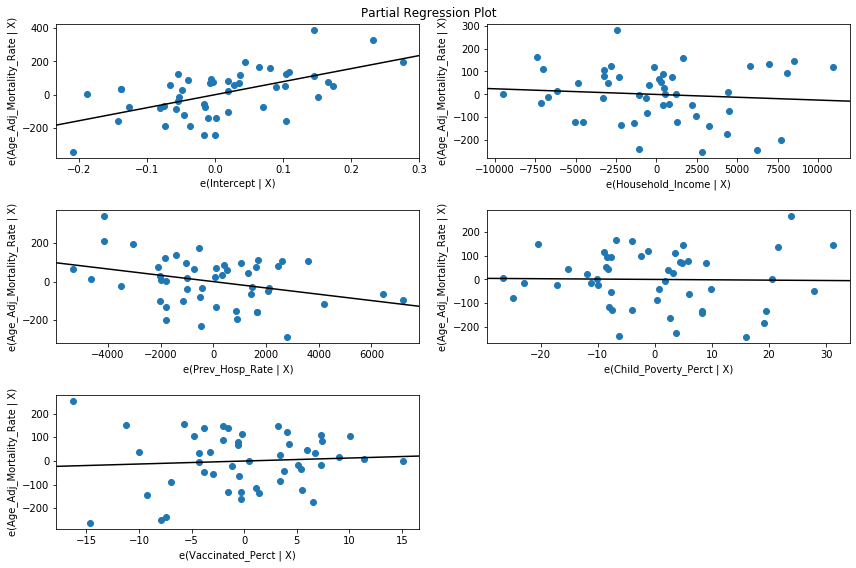

In [1024]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(black_model, fig=fig)

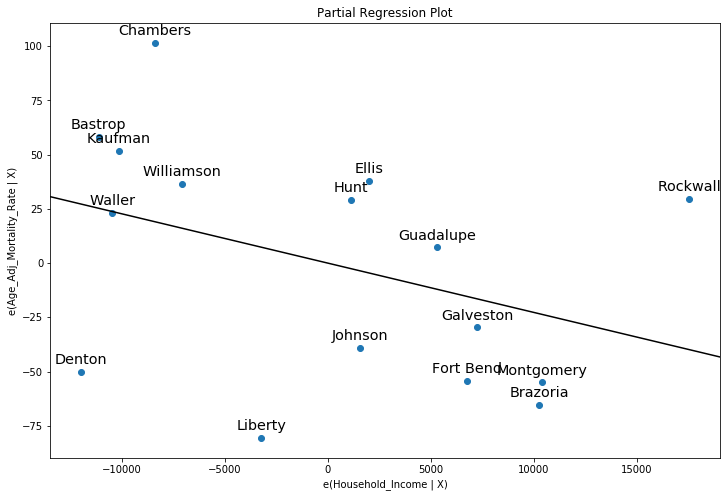

In [1025]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.plot_partregress("Age_Adj_Mortality_Rate", "Household_Income", ["Teen_Birth_Rate", "Prev_Hosp_Rate", "Child_Poverty_Perct","Vaccinated_Perct"],  ax=ax, data=black_suburbs_clean)
